In [1]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout

# just for repeatable results
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


%matplotlib inline

/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shenwanxiang/ana

In [2]:
def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs


def DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = 1):
    
    ## first inputs
    d_inputs1 = Input(molmap1_size)
    d_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(d_inputs1)
    d_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_conv1) #p1
    d_incept1 = Inception(d_pool1, strides = 1, units = 32)
    d_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_incept1) #p2
    d_incept2 = Inception(d_pool2, strides = 1, units = 64)
    d_flat1 = GlobalMaxPool2D()(d_incept2)

    
    ## second inputs
    f_inputs1 = Input(molmap2_size)
    f_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(f_inputs1)
    f_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_conv1) #p1
    f_incept1 = Inception(f_pool1, strides = 1, units = 32)
    f_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_incept1) #p2
    f_incept2 = Inception(f_pool2, strides = 1, units = 64)
    f_flat1 = GlobalMaxPool2D()(f_incept2)    
    
    ## concat
    merge = Concatenate()([d_flat1, f_flat1]) 
    d1 = Dense(256,activation='relu')(merge)
    d1 = Dense(128,activation='relu')(d1)
    d1 = Dense(64,activation='relu')(d1)

    #since the sigmoid function is in loss function, so the activation function should be None
    outputs = Dense(n_outputs, activation=None)(d1)
    
    model = tf.keras.Model(inputs=[d_inputs1, f_inputs1], outputs=outputs)
    
    return model

In [3]:
#load dataset
data = dataset.load_CYP450()
df = data.data

total samples: 16896


# featurizer

In [4]:
X1_name =  './X_descriptor.data'
X2_name =  './X_fingerprint.data'
X_smiles = df.smiles.tolist()

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(X_smiles, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(X_smiles, n_jobs = 8)
    dump(X2, X2_name)
    
MASK = -1
Y = pd.DataFrame(data.y).fillna(MASK).values

# splitting valid set from training set by scaffold

In [5]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit import Chem
getSFD = lambda x:Chem.MolToSmiles(GetScaffoldForMol(Chem.MolFromSmiles(x)))

df['scaffold'] = df.smiles.progress_apply(getSFD)
df_train = df[df['group'] == 'training set'][['scaffold']]
def getValidIdx(x):
    if (len(x) > 5): # set as valid only if this scaffold group larger than 5
        return x.index.tolist()[0]
    else:
        return 
valid_idx = df_train.groupby('scaffold').progress_apply(getValidIdx).dropna().astype(int).tolist()
train_idx = list(set(df_train.index.tolist()) - set(valid_idx))
test_idx = df[df.group == 'test set'].index.tolist()
print(len(train_idx), len(valid_idx), len(test_idx))

train_df = df.iloc[train_idx]
valid_df = df.iloc[valid_idx]
test_df = df.iloc[test_idx]

train_df.to_csv('./train.csv')
valid_df.to_csv('./valid.csv')
test_df.to_csv('./test.csv')

100%|##########| 8163/8163 [00:00<00:00, 271737.45it/s]


13392 195 3309


In [6]:
trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

In [7]:
def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

pos_weights, neg_weights = get_pos_weights(Y[train_idx])
pos_weights

array([1.67457821, 2.64418146, 1.25175936, 6.46067416, 1.9529957 ])

In [8]:
#from model import SinglePathClassificationModel
from loss import cross_entropy, weighted_cross_entropy
from cbks import ClassificationPerformance, EarlyStoppingAtMinLoss

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
loss = lambda y_true, y_pred: weighted_cross_entropy(y_true,y_pred, pos_weights.mean(), MASK)
model = DoublePathClassificationModel(molmap1_size,molmap2_size, n_outputs = Y.shape[1])
earlystop = EarlyStoppingAtMinLoss(patience=10, criteria = 'val_loss')
performace = ClassificationPerformance((trainX, trainY), (validX, validY), MASK)
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model.count_params()

808101

In [10]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) 

epoch: 0001, loss: 0.8892 - val_loss: 0.7758; auc: 0.7890 - auc_val: 0.7961                                                                                                    
epoch: 0002, loss: 0.7744 - val_loss: 0.6906; auc: 0.8308 - auc_val: 0.8593                                                                                                    
epoch: 0003, loss: 0.7223 - val_loss: 0.6347; auc: 0.8562 - auc_val: 0.8819                                                                                                    
epoch: 0004, loss: 0.6926 - val_loss: 0.6036; auc: 0.8701 - auc_val: 0.8981                                                                                                    
epoch: 0005, loss: 0.6750 - val_loss: 0.5975; auc: 0.8771 - auc_val: 0.9041                                                                                                    
epoch: 0006, loss: 0.6643 - val_loss: 0.5824; auc: 0.8832 - auc_val: 0.9124                                             

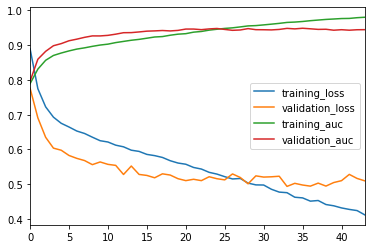

In [11]:
pd.DataFrame(performace.history)[['training_loss', 'validation_loss', 'training_auc', 'validation_auc']].plot()

In [12]:
np.mean(performace.evaluate(testX, testY))

0.8900608386921828

In [13]:
model.save('./model.h5')

In [14]:
train_auc = np.mean(performace.evaluate(trainX, trainY))
valid_auc = np.mean(performace.evaluate(validX, validY))
test_auc = np.mean(performace.evaluate(testX, testY))

print(train_auc, valid_auc, test_auc)

0.9651081903490754 0.9479956209805822 0.8900608386921828


In [15]:
performace.evaluate(validX, validY)

[0.9591250552364118,
 0.9466063348416289,
 0.9352245862884161,
 0.9547244094488188,
 0.9442977190876352]

In [16]:
performace.evaluate(testX, testY)

[0.981700268422187,
 0.8108890185779594,
 0.826703631278002,
 0.9097102599338068,
 0.9213010152489585]

In [17]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss', 'training_auc', 'validation_auc']]
dfp.to_csv('DoublePathModel.csv')

In [18]:
earlystop.best_epoch

33

In [19]:
ls -lh

total 2.8G
-rw-rw-r-- 1 shenwanxiang shenwanxiang  87K Nov 10 11:45 00_count_parameters.ipynb
-rw-rw-r-- 1 shenwanxiang shenwanxiang  55K Nov 10 12:32 01_comparison_multitask.ipynb
-rw-rw-r-- 1 shenwanxiang shenwanxiang 3.5K Nov 10 12:28 DoublePathModel.csv
-rw-rw-r-- 1 shenwanxiang shenwanxiang 2.3G Nov  9 21:00 X_descriptor.data
-rw-rw-r-- 1 shenwanxiang shenwanxiang 516M Nov  9 21:15 X_fingerprint.data
drwxrwxr-x 2 shenwanxiang shenwanxiang 4.0K Nov 10 11:04 __pycache__/
-rw-rw-r-- 1 shenwanxiang shenwanxiang 4.6K Nov 10 11:02 cbks.py
-rw-rw-r-- 1 shenwanxiang shenwanxiang  798 Nov  9 15:23 loss.py
-rw-rw-r-- 1 shenwanxiang shenwanxiang 9.5M Nov 10 12:27 model.h5
-rw-rw-r-- 1 shenwanxiang shenwanxiang 368K Nov 10 12:26 test.csv
-rw-rw-r-- 1 shenwanxiang shenwanxiang 1.6M Nov 10 12:26 train.csv
-rw-rw-r-- 1 shenwanxiang shenwanxiang  23K Nov 10 12:26 valid.csv
